In [ ]:
!apt-get install -y poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  poppler-utils tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 5,002 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 5,002 kB in 2s (3,036 kB/s)
Selecting previously unselected package popp

In [ ]:
!pip install pytesseract easyocr paddlepaddle paddleocr pdf2image pillow jiwer Levenshtein python-doctr pyocr

In [ ]:
!apt-get install -y ghostscript

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 10 newly installed, 0 to remove and 20 not upgraded.
Need to get 16.7 MB of archives.
After this operation, 63.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-droid-fallback all 1:6.0.1r16-1.1build1 [1,805 kB]
Get:2 http://arc

In [ ]:
import time
import cv2
import numpy as np
from PIL import Image
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pytesseract
from paddleocr import PaddleOCR
import easyocr
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import pyocr
import pyocr.builders
from jiwer import wer, cer, Compose, RemovePunctuation, RemoveWhiteSpace, ToLowerCase

def preprocess_image(image_path):
    """Preprocess the image to improve OCR accuracy."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    image = cv2.resize(image, None, fx=300/72, fy=300/72, interpolation=cv2.INTER_CUBIC)  # Set resolution to 300 DPI
    # Apply Gaussian Blur to reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Otsu's thresholding for binarization
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to remove small noise
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    # Apply median blur for further noise reduction
    image = cv2.medianBlur(image, 3)

    preprocessed_path = "preprocessed_image.jpg"
    cv2.imwrite(preprocessed_path, image)
    return preprocessed_path

# Initialize OCR engines globally
paddle_ocr_engine = PaddleOCR(use_angle_cls=True, lang="en")
easyocr_reader = easyocr.Reader(['en'])
doctr_model = ocr_predictor(pretrained=True)

# Define text normalization pipeline
transform = Compose([
    RemovePunctuation(),
    RemoveWhiteSpace(replace_by_space=True),
    ToLowerCase()
])

def ocr_pytesseract(image_path):
    """Performs OCR using Tesseract"""
    try:
        return pytesseract.image_to_string(image_path).strip()
    except Exception as e:
        print(f"Error in Tesseract OCR: {e}")
        return ""

def ocr_paddleocr(image_path):
    """Performs OCR using PaddleOCR"""
    try:
        if not paddle_ocr_engine:
            raise RuntimeError("PaddleOCR engine is not initialized.")
        result = paddle_ocr_engine.ocr(image_path, cls=True)
        return " ".join([line[1][0] for region in result for line in region])  # Extract recognized text
    except Exception as e:
        print(f"Error in PaddleOCR: {e}")
        return ""

def ocr_easyocr(image_path):
    """Performs OCR using EasyOCR"""

    try:
        if not easyocr_reader:
            raise RuntimeError("EasyOCR reader is not initialized.")
        result = easyocr_reader.readtext(image_path)
        return " ".join([line[1] for line in result])  # Extract recognized text
    except Exception as e:
        print(f"Error in EasyOCR: {e}")
        return ""

def ocr_doctr(image_path):
    """Performs OCR using DocTR with correct file input handling."""

    try:
        if not doctr_model:
            raise RuntimeError("DocTR model is not initialized.")
        doc = DocumentFile.from_images(image_path)  # Convert image for DocTR processing
        result = doctr_model(doc)  # Perform OCR
        recognized_text = " ".join([
            word.value for block in result.pages[0].blocks
            for line in block.lines for word in line.words
        ])
        return recognized_text
    except Exception as e:
        print(f"Error in DocTR OCR: {e}")
        return ""


def ocr_pyocr(image_path):
    """Performs OCR using PyOCR."""

    try:
        tools = pyocr.get_available_tools()
        if len(tools) == 0:
          print("No OCR tool found")
        tool = tools[0]
        result = tool.image_to_string(
            Image.open(image_path),
            lang="eng",
            builder=pyocr.builders.TextBuilder()
        )
        return result
    except Exception as e:
        print(f"Error in PyOCR: {e}")
        return ""


def evaluate_ocr(image_path, ground_truth, framework):
    """
    Evaluates OCR output using the selected framework.

    :param image_path: Path to the input image.
    :param ground_truth: The actual text in the image (as a list or string).
    :param framework: OCR framework to use.
    :return: Dictionary containing WER, CER, Precision, Recall, Latency, and Layout Detection.
    """

    # Convert ground_truth list to a single string if necessary
    if isinstance(ground_truth, list):
        ground_truth = " ".join(ground_truth)

    # Select OCR framework
    ocr_function = {
        "Pytesseract": ocr_pytesseract,
        "PaddleOCR": ocr_paddleocr,
        "EasyOCR": ocr_easyocr,
        "DocTR": ocr_doctr,
        "PyOCR": ocr_pyocr,
    }.get(framework)

    if ocr_function is None:
        raise ValueError(f"Unsupported OCR framework: {framework}")

    # Measure latency
    start_time = time.time()
    ocr_output = ocr_function(image_path)
    latency = time.time() - start_time

    # Normalize text
    ground_truth_normalized = transform(ground_truth)
    ocr_output_normalized = transform(ocr_output)

    # Compute Word Error Rate (WER) and Character Error Rate (CER)
    word_error_rate = wer(ground_truth_normalized, ocr_output_normalized)
    char_error_rate = cer(ground_truth_normalized, ocr_output_normalized)

    # Compute Precision and Recall
    truth_chars = set(ground_truth_normalized)
    ocr_chars = set(ocr_output_normalized)

    true_positive = len(truth_chars & ocr_chars)  # Correctly recognized characters
    false_positive = len(ocr_chars - truth_chars)  # Extra characters recognized
    false_negative = len(truth_chars - ocr_chars)  # Missing characters

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    return {
        "WER": word_error_rate,
        "CER": char_error_rate,
        "Precision": precision,
        "Recall": recall,
        "Latency (seconds)": latency,
        "OCR Output": ocr_output
    }

def plot_comparison(metrics):
    # Restructure the data for DataFrame creation
    data = []
    for framework, result_dict in metrics.items():
        result_dict['Framework'] = framework  # Add Framework as a key-value pair
        data.append(result_dict)

    df = pd.DataFrame(data).set_index("Framework")  # Now 'Framework' is a column

    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".3f")
    plt.title("OCR Performance Metrics Heatmap")
    plt.show()

def plot_metrics(metrics):
    # Restructure the data for DataFrame creation
    data = []
    for framework, result_dict in metrics.items():
        result_dict['Framework'] = framework  # Add Framework as a key-value pair
        data.append(result_dict)

    df = pd.DataFrame(data).set_index("Framework")  # Now 'Framework' is a column
    df[['WER', 'CER', 'Latency (seconds)']].plot(kind='bar', figsize=(12, 6))
    plt.title("OCR Frameworks Comparison")
    plt.ylabel("Metric Value")
    plt.show()

[2025/02/11 13:14:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Saving sample_input.png to sample_input.png

OCR Evaluation for Pytesseract:
WER: 0.16666666666666666
CER: 0.03571428571428571
Precision: 0.9230769230769231
Recall: 1.0
Latency (seconds): 0.2875676155090332
OCR Output: Every path 1s
the right path.
[2025/02/11 13:32:59] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.047040700912475586
[2025/02/11 13:32:59] ppocr DEBUG: cls num  : 2, elapsed : 0.011876106262207031
[2025/02/11 13:33:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.13143062591552734

OCR Evaluation for PaddleOCR:
WER: 0.0
CER: 0.0
Precision: 1.0
Recall: 1.0
Latency (seconds): 0.20700716972351074
OCR Output: Every path is the right path.

OCR Evaluation for EasyOCR:
WER: 0.3333333333333333
CER: 0.35714285714285715
Precision: 1.0
Recall: 1.0
Latency (seconds): 1.4481642246246338
OCR Output: Every is the right path. path
Error in DocTR OCR: Given input size: (128x1x16). Calculated output size: (128x0x8). Output size is too small

OCR Evaluation for DocTR:
WER: 1.0
CER: 1.0
Precisi

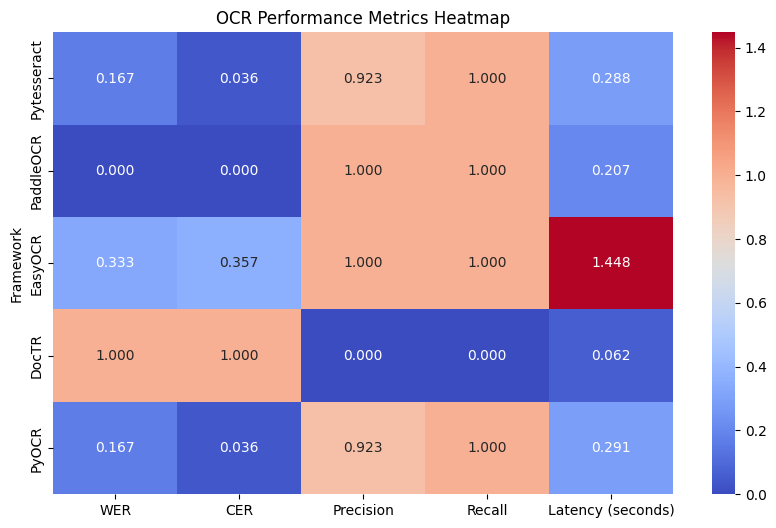

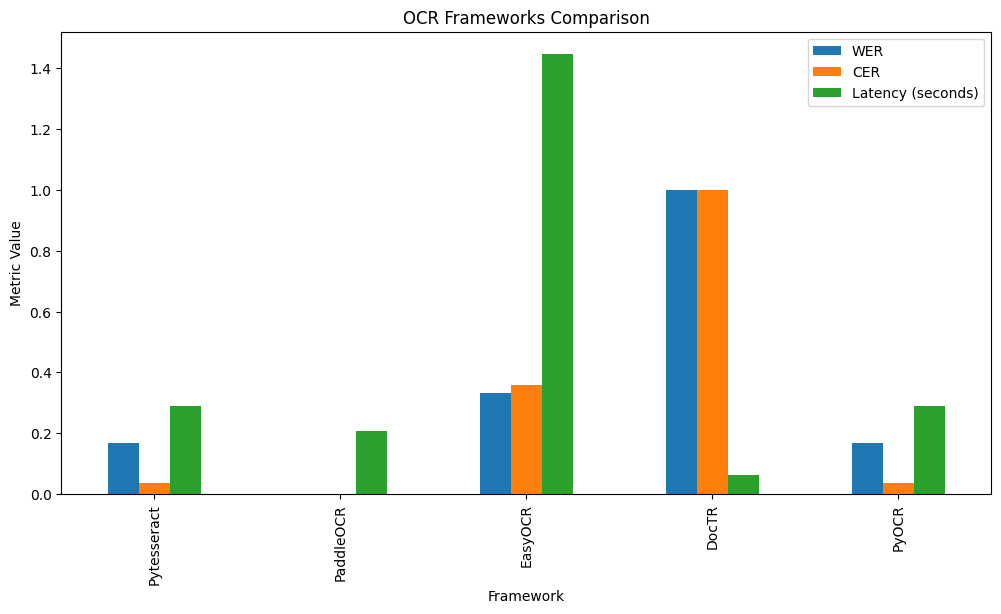

In [30]:
# Upload your PDF
from google.colab import files
uploaded = files.upload()

# Get the filename of the uploaded PDF
pdf_filename = list(uploaded.keys())[0]

# Example usage
if __name__ == "__main__":
    image_path = "sample_input.png"  # Provide the path to your test image
    ground_truth = "Every path is the right path."

    frameworks = ["Pytesseract", "PaddleOCR", "EasyOCR", "DocTR", "PyOCR"]
    all_results = {}

    for framework in frameworks:
        results = evaluate_ocr(image_path, ground_truth, framework)
        print(f"\nOCR Evaluation for {framework}:")

        # Store all metrics except 'OCR Output'
        all_results[framework] = {k: v for k, v in results.items() if k != "OCR Output"}

        # Print all metrics including 'OCR Output'
        for metric, value in results.items():
            print(f"{metric}: {value}")

    plot_comparison(all_results)
    plot_metrics(all_results)